## Imports

In [3]:

import inspect
import os
import sys
# os.chdir('../')
# print(os.getcwd())
# if "experimental_copy_redo" in str(os.getcwd()):
#     os.chdir('../')
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

import random
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

import pandas as pd

import dgl.function as fn
MODEL_NAME = 'GraphSage'

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

"""
    IMPORTING CUSTOM MODULES/METHODS
"""
# from nets.COLLAB_edge_classification.load_net import gnn_model # import all GNNS
from nets.COLLAB_edge_classification.load_net import gnn_model
from data.data import LoadData
"""
    GPU Setup
"""
def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

    if torch.cuda.is_available() and use_gpu:
#         print('cuda available with GPU:',torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
#         print('cuda not available')
        device = torch.device("cpu")
    return device
use_gpu = False; gpu_id = -1; device = None # CPU
# """
#     USER CONTROLS
# """

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [4]:
def load_datset(DATASET_NAME):
    print("[I] Loading data (notebook) ...")
    dataset = LoadData(DATASET_NAME)
    print("[I] Finished loading.....")
    # print(dataset)

    return dataset

## DEFINE PARAMETER

In [5]:

def define_parameter(MODEL_NAME, dataset):
    
#     MODEL_NAME = 'MF'
    # MODEL_NAME = 'GatedGCN'
    
    n_heads = -1
    edge_feat = False
    pseudo_dim_MoNet = -1
    kernel = -1
    gnn_per_block = -1
    embedding_dim = -1
    pool_ratio = -1
    n_mlp_GIN = -1
    gated = False
    self_loop = False
    max_time = 12
    layer_type = 'dgl'
    num_embs = -1
    pos_enc = True
    #pos_enc = False
    pos_enc_dim = 10

    
    if MODEL_NAME == 'MF':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.01; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=0; hidden_dim=256; out_dim=hidden_dim; num_embs=235868;
    
    if MODEL_NAME == 'MLP':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=80; out_dim=hidden_dim; dropout=0.0; readout='mean'; gated = False  # Change gated = True for Gated MLP model
    
    if MODEL_NAME == 'GCN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=5; hidden_dim=74; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'GraphSage':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=10; hidden_dim=38; out_dim=hidden_dim; dropout=0.0; readout='mean'; layer_type='edgefeat'

    if MODEL_NAME == 'GAT':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; n_heads=3; hidden_dim=19; out_dim=n_heads*hidden_dim; dropout=0.0; readout='mean'; layer_type='dgl'
    
    if MODEL_NAME == 'GIN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=60; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'MoNet':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=53; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'GatedGCN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=5; hidden_dim=35; out_dim=hidden_dim; dropout=0.0; readout='mean'; edge_feat = False; layer_type='edgereprfeat'
        
    # generic new_params
    net_params = {}
    net_params['device'] = device
    net_params['in_dim'] = dataset.graph.ndata['feat'].shape[-1]
    net_params['in_dim_edge'] = dataset.graph.edata['feat'].shape[-1]
    net_params['residual'] = True
    net_params['hidden_dim'] = hidden_dim
    net_params['out_dim'] = out_dim
    num_classes = 1
    net_params['n_classes'] = num_classes
    net_params['n_heads'] = n_heads
    net_params['L'] = L  # min L should be 2
    net_params['readout'] = "mean"
    net_params['layer_norm'] = True
    net_params['batch_norm'] = True
    net_params['in_feat_dropout'] = 0.0
    net_params['dropout'] = 0.0
    net_params['edge_feat'] = edge_feat
    net_params['self_loop'] = self_loop
    net_params['layer_type'] = layer_type
    
    # for MF
    net_params['num_embs'] = num_embs
    
    # for MLPNet 
    net_params['gated'] = gated
    
    # specific for MoNet
    net_params['pseudo_dim_MoNet'] = 2
    net_params['kernel'] = 3
    
    # specific for GIN
    net_params['n_mlp_GIN'] = 2
    net_params['learn_eps_GIN'] = True
    net_params['neighbor_aggr_GIN'] = 'sum'
    
    # specific for graphsage
    net_params['sage_aggregator'] = 'maxpool'   
    
    # specific for pos_enc_dim
    net_params['pos_enc'] = pos_enc
    net_params['pos_enc_dim'] = pos_enc_dim

    
    params = {}
    params['seed'] = seed
    params['epochs'] = epochs
    params['batch_size'] = batch_size
    params['init_lr'] = init_lr
    params['lr_reduce_factor'] = lr_reduce_factor 
    params['lr_schedule_patience'] = lr_schedule_patience
    params['min_lr'] = min_lr
    params['weight_decay'] = weight_decay
    params['print_epoch_interval'] = 5
    params['max_time'] = max_time

    return net_params, params
    


## Load Data

In [6]:
def LoadDF(APPLICATION_NAME):
    df = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    return df  

## VIEW MODEL PARAMETER

In [7]:

def view_model_param(MODEL_NAME, net_params):
    # print(net_params)
    model = gnn_model(MODEL_NAME, net_params)
    total_param = 0
    # print("MODEL DETAILS:\n")
    # print(model)
    for param in model.parameters():
        # print(param.data.size())
        total_param += np.prod(list(param.data.size()))
    # print('MODEL/Total parameters:', MODEL_NAME, total_param)
    return total_param

tim1 = time.time()


## Set Parameters

In [8]:
def set_parameters(MODEL_NAME, dataset, DATASET_NAME):
    net_params, params = define_parameter(MODEL_NAME=MODEL_NAME, dataset=dataset)
    config = {}
    gpu = {}
    gpu['use'] = use_gpu
    gpu['id'] = gpu_id
    config['gpu'] = gpu
    # GNN model, dataset, out_dir
    config['model'] = MODEL_NAME
    config['dataset'] = DATASET_NAME
    out_dir = 'out/debug/'
    config['out_dir'] = out_dir
    config['params'] = params
    # network parameters
    config['net_params'] = net_params
    params = config['params']
    DATASET_NAME = config['dataset']
    device = gpu_setup(config['gpu']['use'], config['gpu']['id'])
    out_dir = config['out_dir']
    MODEL_NAME = config['model']
    net_params = config['net_params']
    net_params['device'] = device
    net_params['gpu_id'] = config['gpu']['id']
    net_params['batch_size'] = params['batch_size']
    net_params['in_dim'] = dataset.graph.ndata['feat'].shape[-1]
    net_params['in_dim_edge'] = dataset.graph.edata['feat'].shape[-1]
    net_params['n_classes'] = 1  # binary prediction
    net_params['total_param'] = view_model_param(MODEL_NAME, net_params)
    
    return net_params, params

## Get Epoc Number

In [9]:
def get_EPOC_Number(PATH):
    file_path = PATH+"/ROC_CURVE/*"
    project_list = glob.glob(file_path)
    max_ = -1
    for line in project_list:
        index = line.rfind("_")
        last_index = line.rfind(".png")
        number = int(line[index+1:last_index])
        max_ = max(max_, number)
    # print(max_)
    return max_

## Train Model

In [10]:
def train_model(dataset, EPOC_NUMBER, APPLICATION_NAME, net_params, params, MODEL_NAME):
    t0 = time.time()    
    DATASET_NAME = dataset.name

    if MODEL_NAME in ['GatedGCN']:
        if net_params['pos_enc']:
#             print("[!] Adding graph positional encoding",net_params['pos_enc_dim'])
            dataset._add_positional_encodings(net_params['pos_enc_dim'])
#             print('Time PE:',time.time()-t0)

    graph = dataset.graph
    evaluator=""
    train_edges, val_edges, val_edges_neg, test_edges, test_edges_neg = dataset.train_edges, dataset.val_edges, dataset.val_edges_neg, dataset.test_edges, dataset.test_edges_neg
    device = net_params['device']
    random.seed(params['seed'])
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    if device.type == 'cuda':
        torch.cuda.manual_seed(params['seed'])

#     print("Graph: ", graph)
#     print("Training Edges: ", len(train_edges))
#     print("Validation Edges: ", len(val_edges) + len(val_edges_neg))
#     print("Test Edges: ", len(test_edges) + len(test_edges_neg))

#     print(net_params)
    model = gnn_model(MODEL_NAME, net_params)
    model = model.to(device)
    out_dir = 'out/debug/'
    PATH = out_dir + 'checkpoints/' + MODEL_NAME + "_NEW_DATASET--" + APPLICATION_NAME + "/RUN_/epoch_"+str(EPOC_NUMBER)+".pkl"
    t = torch.load(PATH)
    model.load_state_dict(torch.load(PATH))
#     print(model)

    optimizer = optim.Adam(model.parameters(), lr=params['init_lr'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                        factor=params['lr_reduce_factor'],
                                                        patience=params['lr_schedule_patience'],
                                                        verbose=True)

    return model, graph

## Get Test Data

In [11]:
def get_random_test_data(src_id,test_size, APPLICATION_NAME=""):
    ROOT_PATH = "../prune_new/"
    df = pd.read_csv(ROOT_PATH+ APPLICATION_NAME+'_node.csv')
    nodes_data = df.drop(["start_line","start_column","end_line",  "end_column" ,"file_name"], axis=1)
    
    stmt_type=['FunctionDeclaration', 'ArrowFunctionExpression', 'FunctionExpression']
    df1 = nodes_data[nodes_data.type.isin(stmt_type)]
    test_neg_id = df1['new_id'].tolist()

    df1 = nodes_data[((nodes_data['type']=='CallExpression')|(nodes_data['type']=='NewExpression'))]
    test_neg_call_site = df1['new_id'].tolist()

    test_edges= pd.read_csv(ROOT_PATH+ APPLICATION_NAME +'_function_edges.csv')

    test_edges.columns = ["src", "dst"]
    index = pd.MultiIndex.from_product([test_neg_call_site, test_neg_id], names = ["src", "dst"])
    all_combi = pd.DataFrame(index = index).reset_index()
    
    test_neg_df =  pd.merge(all_combi,test_edges, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    test_neg_df = test_neg_df.iloc[np.random.permutation(len(test_neg_df))]
    test_neg_df = test_neg_df[test_neg_df['src']==src_id]
    test_neg_df = test_neg_df[:test_size]
    test_edges = torch.from_numpy(test_neg_df.to_numpy())
    return test_edges
#     return test_neg_df

In [12]:
def get_test_data(file_name, src_id, APPLICATION_NAME):
    # print(src_id)
    f = open('candidate_edge_files/'+APPLICATION_NAME+'_candidate_edges.json')
    data = json.load(f)
    u=[]
    v=[]
    test_neg_id = data[file_name]
    done_list={}
    for node in test_neg_id:
        if (src_id,node) not in done_list:
                u.append(src_id)
                v.append(node)
                done_list[(src_id,node)]=True

    d={'src':u, 'dst':v}
    test_df = pd.DataFrame(d)
    test_edges = torch.from_numpy(test_df.to_numpy())
    random_test_edge={}
    return test_edges, random_test_edge

## Get Candidate

In [13]:
import traceback

def get_candidates(PATH, EPOC_NUMBER, model, graph, params, DATASET_NAME, MODEL_NAME, APPLICATION_NAME, SOURCE_ID, TARGET):
    node_df_org = pd.read_csv("../new/"+APPLICATION_NAME+"_node.csv")
    node_df = node_df_org[node_df_org['new_id']==SOURCE_ID].reset_index(drop=True)
    # print(node_df)
    total = 0
    all_edges = []
    try:
        file_name = node_df.iloc[0]['file_name']
        name = node_df.iloc[0]['name']
        start_line = node_df.iloc[0]['start_line']
        start_column = node_df.iloc[0]['start_column']
        src_id = node_df.iloc[0]['new_id']
        start_time = time.time()
        test_edges, random_test_edge = get_test_data(file_name, src_id, APPLICATION_NAME)
        print("TIME TO GET CANDIATE ===> ", start_time-time.time()," seconds")
        start_time = time.time()
        print(file_name, name)
        if len(test_edges) > 0:
            test_edges, test_pred = evaluate_network(
                        model, device, graph, test_edges, params['batch_size'], DATASET_NAME=DATASET_NAME, MODEL_NAME=MODEL_NAME, SOURCE_NODE=src_id, APPLICATION_NAME=APPLICATION_NAME, TARGET=TARGET)
        print("TIME TO EVALUATE ===> ", start_time-time.time()," seconds")
    except:
        traceback.print_exc()
        pass
    random_test_edges, random_test_pred = {}, {}
    return test_edges, test_pred, random_test_edges, random_test_pred


## Evaluate Network

In [14]:
def evaluate_network(model, device, graph, test_edges,
                     batch_size, DATASET_NAME="", MODEL_NAME="", SOURCE_NODE=0, DST_NODE=0, APPLICATION_NAME="", EPOC_NUMBER=0, TARGET=0):
    
    model.eval()
    with torch.no_grad():
        graph = graph.to(device)
        x = graph.ndata['feat'].to(device)
        e = graph.edata['feat'].to(device).float()
        try:
            x_pos_enc = graph.ndata['pos_enc'].to(device)
            h = model(graph, x, e, x_pos_enc) 
        except:
            h = model(graph, x, e)

        test_edges = test_edges.to(device)
        
#         print("Test edges", test_edges)

        test_preds = []
        for perm in DataLoader(range(test_edges.size(0)), batch_size):
            edge = test_edges[perm].t()
            # print("edge ==> ",edge, len(edge))
            test_preds += [model.edge_predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
#         print(test_preds)
        if len(test_edges)==1:
            t= test_preds[0]
            t =np.expand_dims(t,0)
            t = torch.tensor(t)
            test_preds = [t]
        test_pred = torch.cat(test_preds, dim=0)
    return test_edges, test_pred

        


## Plot graphs for TPR vs EPOC

In [15]:
def plot_figure(main_lst, APPLICATION_NAME, MODEL_NAME):
    import matplotlib.pyplot as plt
    import seaborn as sns
    try:
        os.makedirs('figures/'+APPLICATION_NAME)
    except:
        pass
    # try:
    #     os.makedirs('figures/'+APPLICATION_NAME+"/"+MODEL_NAME)
    # except:
    #     pass

    for i in range(len(main_lst[0])):
        lst = [tensor[i].item() for tensor in main_lst]
        # plt.plot(lst)

        max_index = lst.index(max(lst))
        print(max_index)
        sns.lineplot(x=range(len(lst)), y=lst)
        
        # plt.show()
    plt.savefig('figures/'+APPLICATION_NAME+"/"+MODEL_NAME+"_fpr_vs_epoc.pdf")
    plt.close()


In [16]:
def get_optimal_index(main_lst):
    index_list = []
    for i in range(len(main_lst[0])):
        lst = [tensor[i].item() for tensor in main_lst]
        max_index = lst.index(max(lst))
        index_list.append(max_index)
        # sns.lineplot(x=range(len(lst)), y=lst)
        # plt.xlabel('X-axis Label')
        # plt.ylabel('Y-axis Label')
        # plt.title('Plot of a List of Values')
        # plt.show()
        # plt.savefig("figures/"+str(i)+".pdf")
        # plt.close()
    print(index_list)
    print(np.median(index_list))


In [17]:
# MODEL_NAME = 'GatedGCN'

# to_do_list = ['formula-parser']
# app_list = ['formula-parser']

# # print(os.getcwd())
# # if "experimental_copy_redo" not in str(os.getcwd()):
# #     os.chdir('experimental_copy_redo/')
# # print(os.getcwd())

# for i in range(len(to_do_list)):
#     main_lst = []
#     APPLICATION_NAME = app_list[i]
#     DATASET_NAME = 'NEW_DATASET--'+APPLICATION_NAME
#     PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
#     EPOCS = get_EPOC_Number(PATH=PATH)
#     dataset = load_datset(DATASET_NAME)
#     net_params, params = set_parameters(MODEL_NAME, dataset, DATASET_NAME)
#     for EPOC_NUMBER in range(1,EPOCS+1):    
#         model, graph = train_model(dataset, EPOC_NUMBER, APPLICATION_NAME, net_params, params, MODEL_NAME)
#         test_df = get_function_edge("../prune_new/"+ APPLICATION_NAME +'_function_edges.csv')
#         # print(test_edges)
#         # output_file = open(APPLICATION_NAME+"_missing_edge_log.txt","w+")
#         node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
#         test_edges = torch.from_numpy(test_df.to_numpy())

#         test_edges, test_pred = evaluate_network(
#                             model, device, graph, test_edges, params['batch_size'], DATASET_NAME=DATASET_NAME, MODEL_NAME=MODEL_NAME, SOURCE_NODE=0, APPLICATION_NAME=APPLICATION_NAME, TARGET=0)
#         cutoff_thrshld = 0.8
#         # print(test_pred)
#         main_lst.append(test_pred)
#     plot_figure(main_lst, APPLICATION_NAME, MODEL_NAME)
#     get_optimal_index(main_lst)


In [18]:
# MODEL_NAME = 'GatedGCN'

# to_do_list = ['Inquirer.js', 'underscore', 'angular', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'through2', 'classnames', 
# 'body-parser', 'uuid', 'async', 'tslib', 'rxjs', 'core', 'package','q', 'node-fs-extra', 'request', 'minimist', 
# 'prop-types','debug', 'axios', 'colors.js','react']
# app_list =  ['Inquirer.js', 'underscore', 'angular', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'through2', 'classnames', 
# 'body-parser', 'uuid', 'async', 'tslib', 'rxjs', 'core', 'package','q', 'node-fs-extra', 'request', 'minimist', 
# 'prop-types','debug', 'axios', 'colors.js','react']


# for i in range(len(to_do_list)):
#     main_lst = []
#     APPLICATION_NAME = app_list[i]
#     DATASET_NAME = 'NEW_DATASET--'+APPLICATION_NAME
#     PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
#     EPOCS = get_EPOC_Number(PATH=PATH)
#     print(EPOCS)
#     dataset = load_datset(DATASET_NAME)
#     net_params, params = set_parameters(MODEL_NAME, dataset, DATASET_NAME)
#     EPOC_NUMBER = EPOCS
#     model, graph = train_model(dataset, EPOC_NUMBER, APPLICATION_NAME, net_params, params, MODEL_NAME)
#     test_df = get_function_edge(APPLICATION_NAME)
#     node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
#     test_edges = torch.from_numpy(test_df.to_numpy())

#     test_edges, test_pred = evaluate_network(
#                         model, device, graph, test_edges, params['batch_size'], DATASET_NAME=DATASET_NAME, MODEL_NAME=MODEL_NAME, SOURCE_NODE=0, APPLICATION_NAME=APPLICATION_NAME, TARGET=0)
#     cutoff_thrshld = 0.8
#     # main_lst.append(test_pred)
#     # plot_figure(main_lst, APPLICATION_NAME, MODEL_NAME)
#     # get_optimal_index(main_lst)

#     import seaborn as sns
#     import matplotlib.pyplot as plt

#     print(test_pred)

#     # Create a histogram plot using Seaborn
#     sns.histplot(test_pred, bins=10, kde=True, color='skyblue')

#     # Customize the plot (optional)
#     plt.title('Histogram Plot')
#     plt.xlabel('Values')
#     plt.ylabel('Frequency')

#     # Show the plot
#     # plt.show()
#     plt.savefig("figures/"+APPLICATION_NAME+"_histogram_"+MODEL_NAME+".pdf")
#     plt.close()


In [19]:
def get_file_name(src):
    node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    node_df = node_df_org[node_df_org['new_id']==src].reset_index(drop=True)
    file_name = node_df.iloc[0]['file_name']

    return file_name
   

In [114]:
# to_do_list =['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
#              'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
#              'eslint-plugin-react', 'axios', 'react']
app_list =  ['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
             'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
             'eslint-plugin-react', 'axios', 'react', 'chai', 'autoprefixer', 'winston', 'node-semver', 'html-webpack-plugin', 'qs', 'chokidar', 'postcss', 'ejs', 
             'morgan', 'mysql', 'Inquirer.js', 'jest', 'rxjs', 'node-fs-extra', 'socket.io', 'joi','node-jsonwebtoken','UglifyJS','ws','create-react-app']
# app_list = ['mysql', 'joi','node-jsonwebtoken', 'create-react-app', 'react-router', 'UglifyJS', 'ws']

# to_do_list =['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'express', 'async', 'jquery', 
#              'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
#              'eslint-plugin-react', 'axios', 'react']
# app_list =  ['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'express', 'async', 'jquery', 
#              'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
#              'eslint-plugin-react', 'axios', 'react']
value_main_lst = []

for APPLICATION_NAME in app_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv("left_out_csv/leftout_"+APPLICATION_NAME+".csv")
        # print(df)
        dst_dict = dict(df.values)

        main_lst = []
        lst = []
        with open("missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", "r+") as in_file:
            for line in in_file:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                else:
                    lst.append(line)
        count = 0
        print(len(main_lst))
        rank_lst =[]
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            
            if len(result_df)>0:
                TARGET = dst_dict[src]
                found = False
                for i in range(len(result_df)):
                    id = result_df.iloc[i]['id']
                    if id == TARGET:
                        rank_lst.append(i)
                        found = True

        count_dict={}
        for i in range(0, 22):
            count_dict[i] = 0
        
        for x in rank_lst:
            if x >20:
                if 21 in count_dict:
                    count= count_dict[21]
                    count_dict[21]=count+1
                else:
                    count_dict[21]=1
            else:
                if x in count_dict:
                    count= count_dict[x]
                    count_dict[x]=count+1
                else:
                    count_dict[x]=1
                    
        # for x in range(21):
        #     xticks_list.append(str(x))
        # xticks_list.append('20+')
        
        count_dict = dict(sorted(count_dict.items()))
        # print(count_dict)
        # print(xticks_list)
        # print(APPLICATION_NAME, "======> ", count, count/len(main_lst)*100)
        # len(rank_lst)
        # print(rank_list)
        categories = list(count_dict.keys())
        counts = list(count_dict.values())
        if all(v == 0 for v in counts):
            print("ALL ZEROOOOOOOOOOOOOOOS ====> ", APPLICATION_NAME)
        value_main_lst.append(counts)
        
        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        print(APPLICATION_NAME, perc_lst[0])
    except:
        raise

print(value_main_lst)

# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(16, 8))
# xticks_list=[]
# categories =[x for x in range(22)]
# for x in range(21):
#     xticks_list.append(str(x))
# xticks_list.append('20+')
# for counts in value_main_lst:
    
#     # Create a bar plot using Seaborn
#     # ax = sns.barplot(x=categories, y=counts)
#     ax = sns.lineplot(x=categories, y=counts)
# plt.xticks(range(len(xticks_list)), xticks_list)
# plt.title('Histogram of Candidate Ranking')
# plt.xlabel('Ranking')
# plt.ylabel('Count')
#     # plt.savefig("candidate_figures/positive_"+APPLICATION_NAME+".pdf")
#     # plt.close()


lodash
227
lodash 57
underscore
302
underscore 14
eslint-plugin-import
81
eslint-plugin-import 51
mocha
207
mocha 52
angular
106
angular 56
ramda
433
ramda 75
shelljs
60
shelljs 32
js-yaml
70
js-yaml 35
bluebird
305
bluebird 32
express
124
express 59
async
245
async 27
jsPDF
1638
jsPDF 22
jquery
169
jquery 25
coffeescript
1255
coffeescript 37
handlebars.js
105
handlebars.js 32
bootstrap
161
bootstrap 39
immutable-js
95
immutable-js 11
package
110
package 22
q
74
q 24
formula-parser
285
formula-parser 70
atompm
428
atompm 12
request
74
request 40
mongoose
576
mongoose 43
mathjs
750
mathjs 51
less.js
410
less.js 28
webpack
642
webpack 39
eslint-plugin-react
238
eslint-plugin-react 32
axios
133
axios 20
react
106
react 53
chai
32
chai 33
autoprefixer
105
autoprefixer 44
winston
51
winston 33
node-semver
63
node-semver 61
html-webpack-plugin
41
html-webpack-plugin 73
qs
64
qs 35
chokidar
90
chokidar 25
postcss
45
postcss 37
ejs
39
ejs 37
morgan
35
morgan 32
mysql
145
mysql 25
Inquirer.js
3

In [ ]:
new_lst =  []
for index in range(len(value_main_lst)):
    lst = value_main_lst[index]
    # print(lst)
    cumsum_lst = np.cumsum(lst)
    # print(cumsum_lst)
    perc_lst = 100*cumsum_lst/np.sum(lst)
    perc_lst = [int(x) for x in perc_lst]
    # print(perc_lst)
    new_lst.append(perc_lst[0])

df =pd.DataFrame({"name":app_list, "val":new_lst})
df = df.sort_values(by=['val'], ascending=True).reset_index(drop=True)
df

In [140]:
app_list =  ['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
             'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
             'eslint-plugin-react', 'axios', 'react', 'chai', 'autoprefixer', 'winston', 'node-semver', 'html-webpack-plugin', 'qs', 'chokidar', 'postcss', 'ejs', 
             'morgan', 'mysql', 'Inquirer.js', 'jest', 'rxjs', 'node-fs-extra', 'socket.io', 'joi','node-jsonwebtoken','UglifyJS','ws','create-react-app']

len(app_list)

50

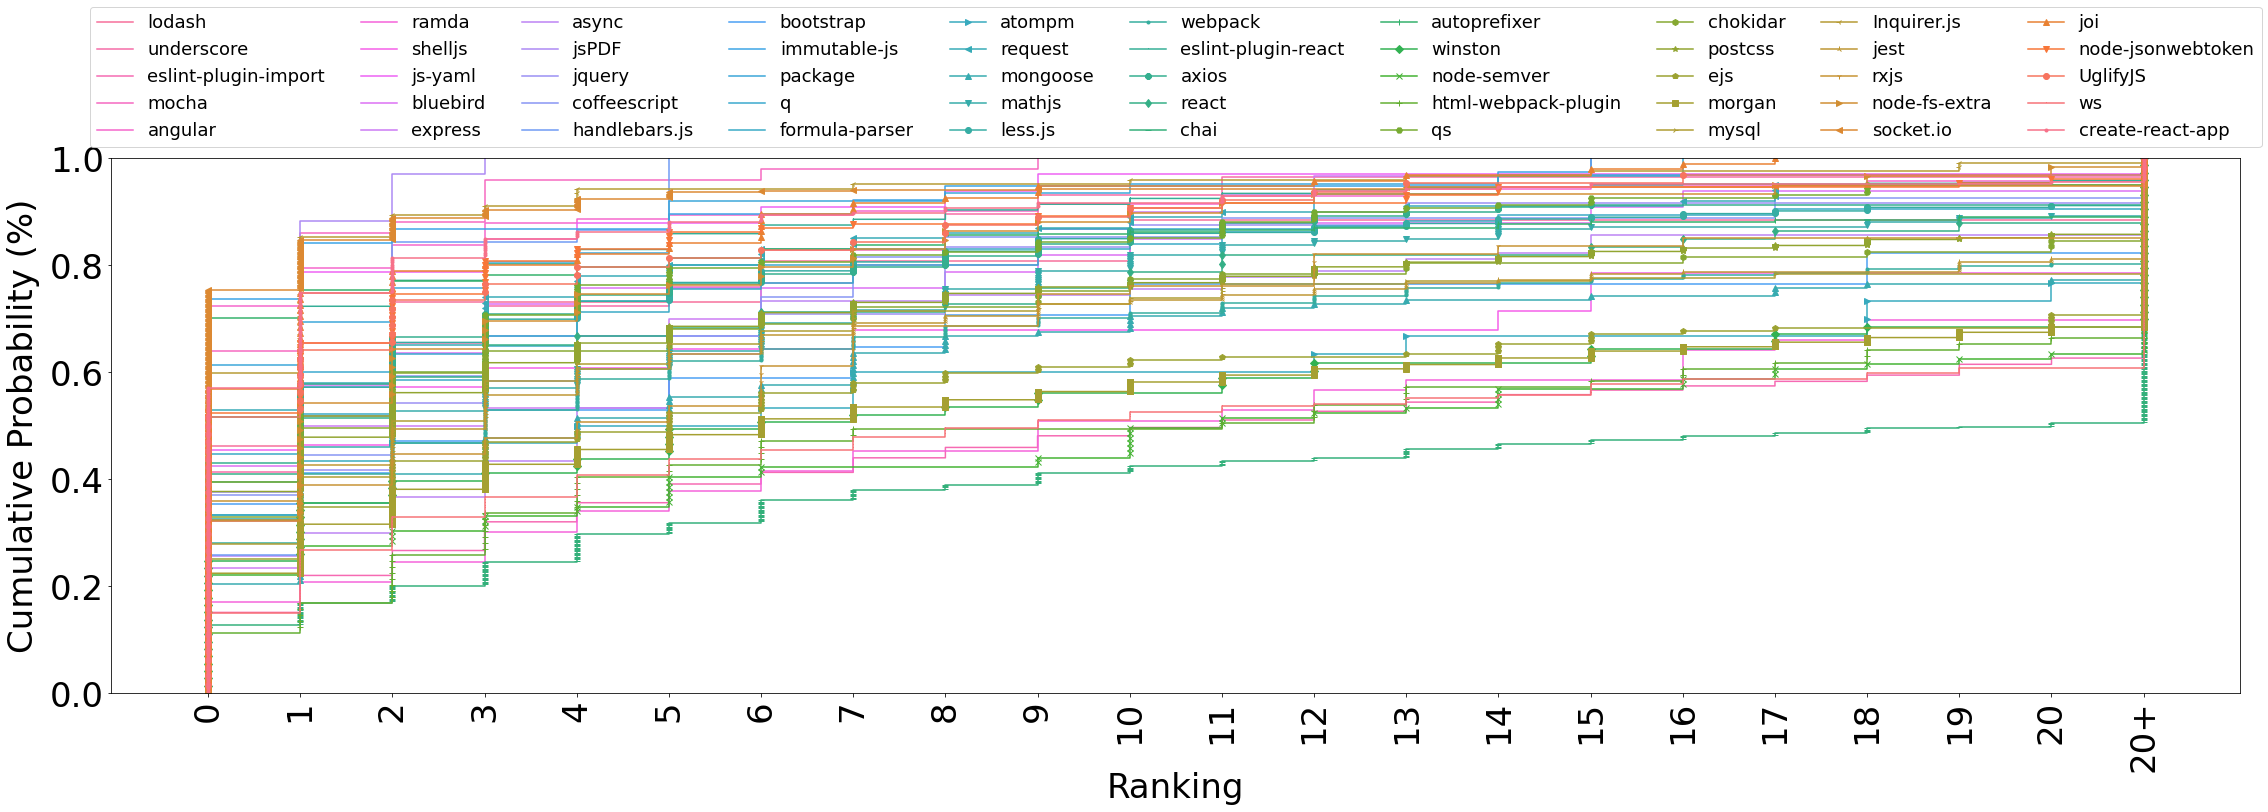

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

values = []
tag = []
for index in range(len(value_main_lst)):
    lst = value_main_lst[index]
    tmp_values = []
    for x in range(len(lst)):
        tmp = [x for i in range(lst[x])]
        tmp_values+=tmp
    values+=tmp_values
    tag += [app_list[index] for i in range(len(tmp_values))]

fig, ax1 = plt.subplots()
sns.set_palette("deep")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(16, 8))
df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(21)]
for x in range(21):
    xticks_list.append(str(x))
xticks_list.append('20+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

sns.ecdfplot(data=df, x="values", hue="tag", ax=ax1)
for lines, marker, legend_handle in zip(ax1.lines[::-1], markers, ax1.legend_.legendHandles):
    lines.set_marker(marker)
    # legend_handle.set_marker(marker)
plt.xticks(range(len(xticks_list)), xticks_list)
# plt.legend(ncol=3)

# plt.title('Histogram of Candidate Ranking')
plt.xlabel('Ranking')
plt.ylabel('Proportion')
plt.subplots_adjust(top = 0.99, bottom = 0.2, right = 0.95, left = 0.05, 
            hspace = 0, wspace = 0)

fs=34
font_size = 18

plt.ylabel("Cumulative Probability (%)", fontsize=fs, labelpad=10)
plt.xlabel("Ranking", fontsize=fs, labelpad=0)
ax1.legend(app_list, loc='upper center', bbox_to_anchor=(0.5, 1.30), ncol=10, prop={'size':font_size})
# ax1.legend(app_list,ncol=2, prop={'size':font_size})
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='y', which='major', labelsize=fs)
plt.tick_params(axis='x', which='major', labelsize=fs, rotation=90)
plt.rcParams["figure.figsize"] = (32, 12)
plt.tight_layout()
# plt.savefig("transfer_learning.pdf",bbox_inches='tight', pad_inches=0, transparent=True)
plt.savefig("candidate_figures/combioned_distribution.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
# to_do_list =['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
#              'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
#              'eslint-plugin-react', 'axios', 'react']
# app_list = ['lodash', 'eslint-plugin-import', 'mocha', 'ramda', 'jquery', 'coffeescript', 'q','request', 'mongoose', 'mathjs' ]

app_list = ['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
             'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
             'eslint-plugin-react', 'axios', 'react', 'chai', 'autoprefixer', 'winston', 'node-semver', 'html-webpack-plugin', 'qs', 'chokidar', 'postcss', 'ejs', 
             'morgan', 'url-loader', 'Inquirer.js', 'jest', 'rxjs', 'node-fs-extra', 'socket.io']
values = []
tag = []
for index in range(len(value_main_lst)):
    lst = value_main_lst[index]
    tmp_values = []
    for x in range(len(lst)):
        tmp = [x for i in range(lst[x])]
        tmp_values+=tmp
    values+=tmp_values
    tag += [app_list[index] for i in range(len(tmp_values))]

fig, ax1 = plt.subplots()
sns.set_palette("deep")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(16, 8))
df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(21)]
for x in range(21):
    xticks_list.append(str(x))
xticks_list.append('20+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

sns.ecdfplot(data=df, x="values", hue="tag", ax=ax1)
for lines, marker, legend_handle in zip(ax1.lines[::-1], markers, ax1.legend_.legendHandles):
    lines.set_marker(marker)
    # legend_handle.set_marker(marker)
plt.xticks(range(len(xticks_list)), xticks_list)
# plt.legend(ncol=3)

# plt.title('Histogram of Candidate Ranking')
plt.xlabel('Ranking')
plt.ylabel('Proportion')
plt.subplots_adjust(top = 0.99, bottom = 0.2, right = 0.95, left = 0.05, 
            hspace = 0, wspace = 0)

fs=34
font_size = 18

plt.ylabel("Proportion", fontsize=fs, labelpad=10)
plt.xlabel("Ranking", fontsize=fs, labelpad=0)
# plt.ylim(-1,1)
# plt.xlim(0,4)
# plt.setp(ax.get_legend().get_texts(), fontsize=fs)
# plt.legend(prop={'size':fs}, loc='best')
# ax.tick_params(axis='both', which='major', pad=12)
# ax.tick_params(axis='y', which='major', labelsize=fs)
# ax.tick_params(axis='x', which='major', labelsize=fs)
# ax1.legend(app_list, loc='lower right', ncol=6, prop={'size':font_size})
ax1.legend(app_list, loc='upper center', bbox_to_anchor=(0.5, 1.30), ncol=10, prop={'size':font_size})
# ax1.legend(app_list,ncol=2, prop={'size':font_size})
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='y', which='major', labelsize=fs)
plt.tick_params(axis='x', which='major', labelsize=fs, rotation=90)
plt.rcParams["figure.figsize"] = (32, 12)
plt.tight_layout()
# plt.savefig("transfer_learning.pdf",bbox_inches='tight', pad_inches=0, transparent=True)
plt.savefig("candidate_figures/combioned_distribution.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

IndexError: list index out of range

In [123]:
import statistics
from collections import Counter


values = []
tag = []
new_lst = []
for index in range(len(value_main_lst)):
    lst = value_main_lst[index]
    cumsum_lst = np.cumsum(lst)
    perc_lst = 100*cumsum_lst/np.sum(lst)
    perc_lst = [int(x) for x in perc_lst]
    new_lst.append(perc_lst[5])
# # print(values
new_lst.sort()
print(len(new_lst))
print(new_lst)
print(max(new_lst))
print(statistics.median(new_lst))
print(min(new_lst))
d =Counter(new_lst)

count = 0
for key in d:
    if key>50:
        count+= d[key]
print(count/len(new_lst))
weighted_sum = 0
total_weight = 0
for i in range(len(app_list)):
    APPLICATION_NAME = app_list[i]
    df = pd.read_csv("left_out_csv/leftout_"+APPLICATION_NAME+".csv")
    weighted_sum+= len(df)*(new_lst[i]/100)
    total_weight+=len(df)
# len(new_lst), len(app_list)

print(weighted_sum/total_weight)


50
[31, 37, 39, 40, 42, 43, 48, 49, 50, 52, 53, 55, 58, 62, 63, 63, 63, 64, 65, 66, 66, 68, 68, 68, 70, 73, 75, 75, 75, 76, 76, 76, 79, 80, 80, 81, 81, 84, 85, 86, 87, 88, 89, 89, 91, 93, 94, 96, 100, 100]
100
71.5
31
0.82
0.7212615931066237


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 8))
xticks_list=[]
categories =[x for x in range(22)]
for x in range(21):
    xticks_list.append(str(x))
xticks_list.append('20+')
for counts in value_main_lst:
    
    # Create a bar plot using Seaborn
    # ax = sns.barplot(x=categories, y=counts)
    ax = sns.lineplot(x=categories, y=counts)
plt.xticks(range(len(xticks_list)), xticks_list)
plt.title('Histogram of Candidate Ranking')
plt.xlabel('Ranking')
plt.ylabel('Count')

In [ ]:
import pandas as pd
to_do_list =['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
             'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
             'eslint-plugin-react', 'axios', 'react']

MODEL_NAME = 'GatedGCN'
lst =[]
for APPLICATION_NAME in to_do_list:
    from os.path import exists
    file_exists = exists("missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_"+MODEL_NAME+".txt")
    if not file_exists:
        df = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
        print(APPLICATION_NAME, " =======> Not available, ", len(df))
        lst.append(APPLICATION_NAME)

print(lst)
